# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Definitions

In [204]:
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'

PATH_TO_SAVE_DATA = "../../data/"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
# definitons
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first pop?
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of days that will mute
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 
R_POP_LOST = 0.05 # Ratio of lost individuals in population 

## Read in the family information and sample submission

In [8]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [229]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [230]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [9]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [10]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    #print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    #print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    #print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [17]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 672254.0276683343
Timing:  380.70853185653687


In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [360]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

,all_choices,first_choices,mid_choices,last_choices
1,11568,4391,4449,2728
2,1806,501,729,576
3,3607,1021,1526,1060
4,3872,1148,1585,1139
5,3907,1181,1544,1182


Text(0.5, 1.0, 'all choices')

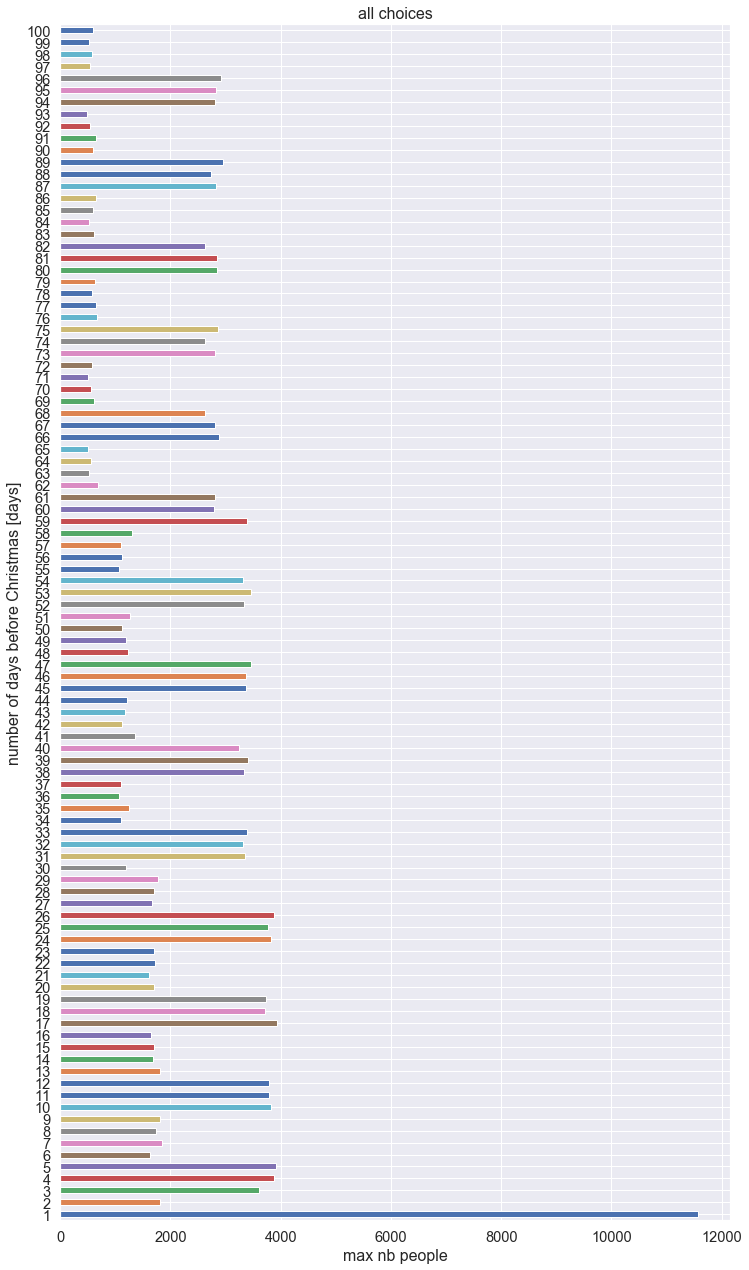

In [361]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

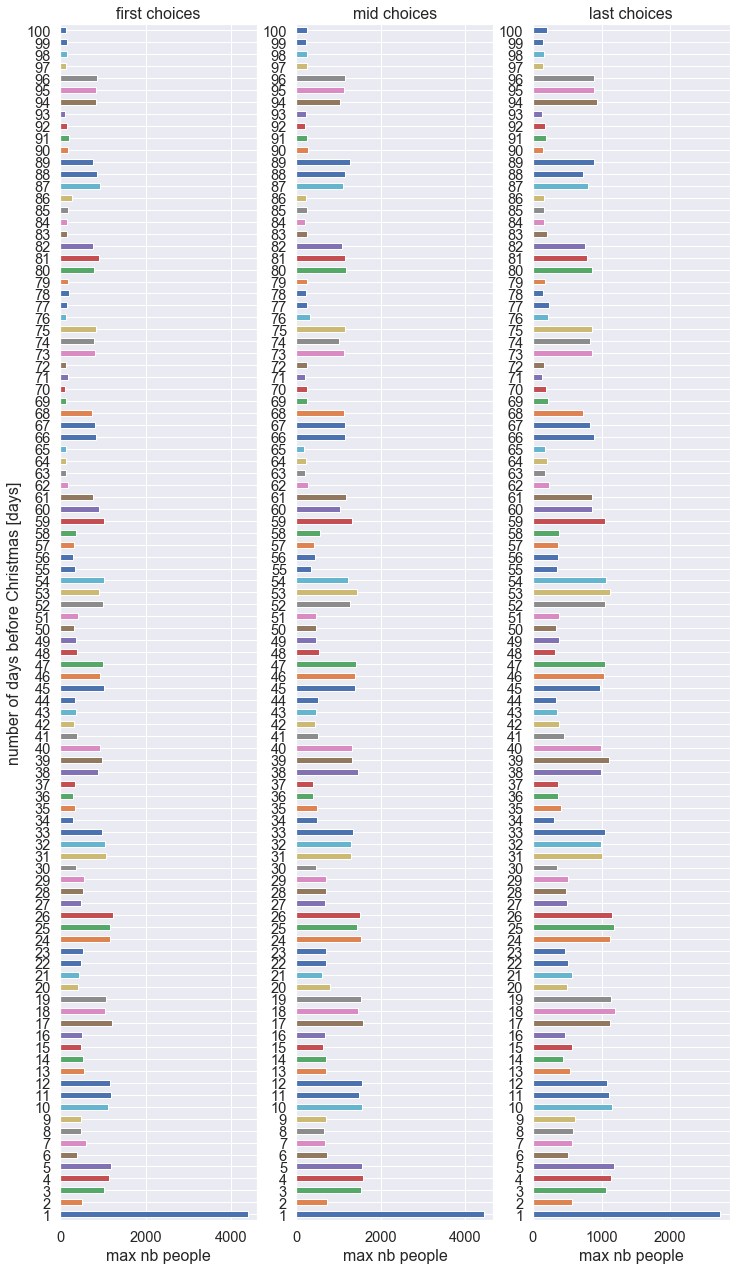

In [359]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [368]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [369]:
df_prob_day.head()

,all_choices,prob
1,11568,0.001098
2,1806,0.007036
3,3607,0.003523
4,3872,0.003282
5,3907,0.003252


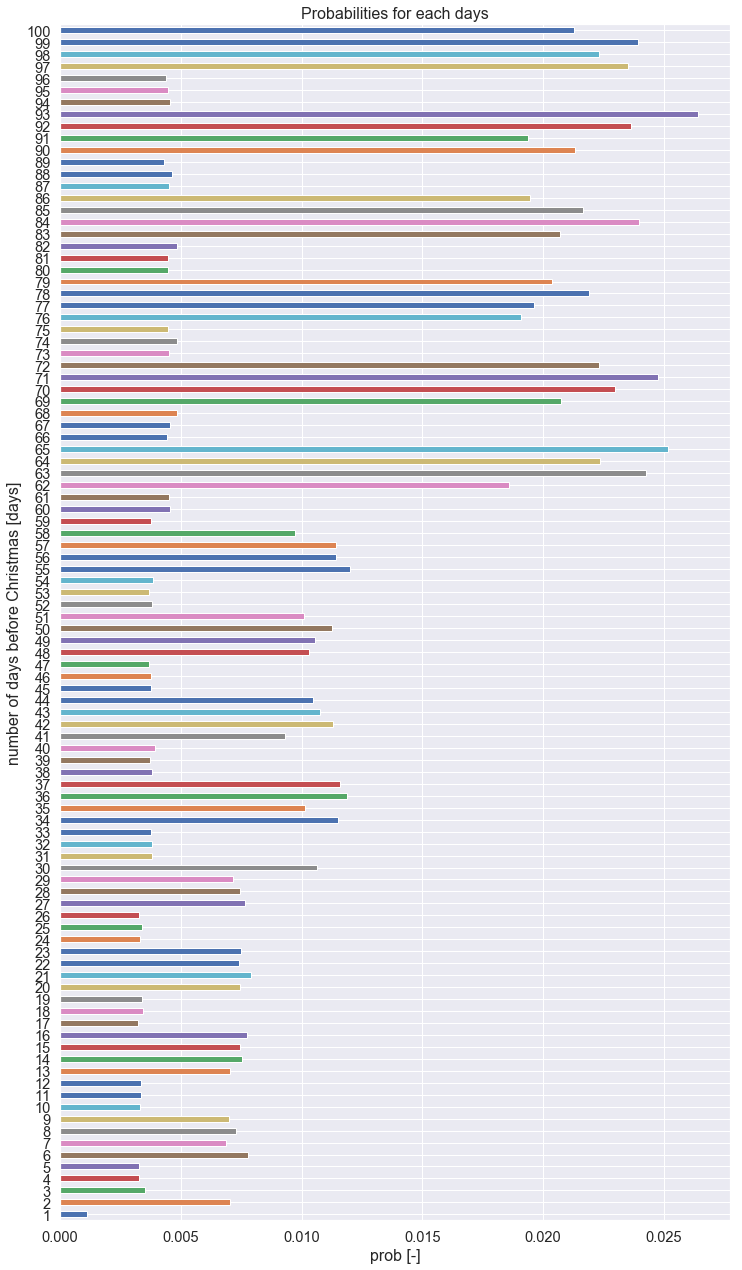

In [371]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

In [315]:
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
5,32,59,12,3,60,26,35,50,5,2,4
6,88,4,1,3,91,32,39,57,28,99,2
7,25,11,52,48,10,17,88,50,95,66,5
8,18,60,1,12,89,33,16,10,53,67,4


## Explore family choice cost

In [25]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [29]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

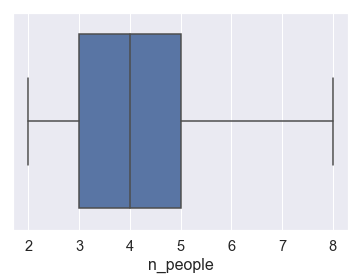

In [11]:
ax = sns.boxplot(x=data["n_people"])


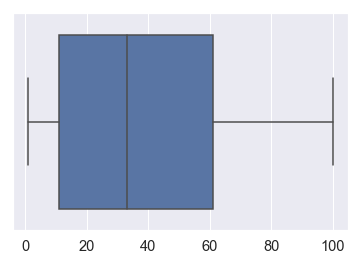

In [176]:
ax = sns.boxplot(data)

In [24]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [32]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


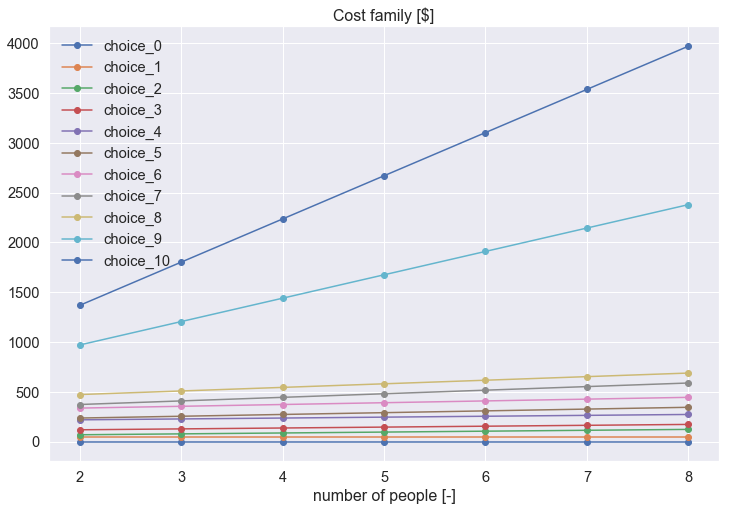

In [43]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

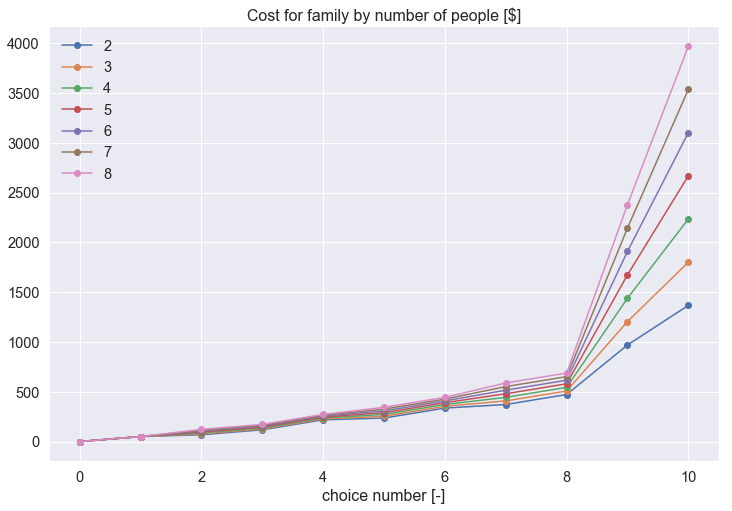

In [70]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [122]:
# For genetic algo, for start population or mutation,
# try to assign probabilities of choice for each possibilities : 
# from  choice 0 to 10.
df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


In [116]:
df_prob = df_fam_cost.filter(items=list_choice)

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


## Creation of days probabilities by family

In [ ]:
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]

In [411]:
df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
family_id,,,,,,,,,,,,,,,,,,,,,
0,0.000566422,0.00362811,0.00181657,0.00169225,0.00167709,0.00402233,0.00354182,0.00376573,0.00360417,0.0484496,...,0.0100036,0.0122018,0.0136224,0.00233846,0.00231124,0.0022509,0.012134,0.0115156,0.0123397,0.0109755
1,0.000566422,0.00362811,0.00181657,0.052932,0.0521334,0.0516726,0.00354182,0.00376573,0.00360417,0.00171036,...,0.0100036,0.0122018,0.0136224,0.00233846,0.00231124,0.0022509,0.012134,0.0115156,0.0123397,0.0109755
2,0.000568389,0.00364071,0.00182288,0.00169812,0.00168291,0.00403629,0.00355412,0.00377881,0.00361668,0.0496736,...,0.0100384,0.0122442,0.0136697,0.00234658,0.00231927,0.00225872,0.0121762,0.0115556,0.0123825,0.0621619
3,0.0505764,0.0542657,0.00182905,0.00170387,0.00168861,0.0525576,0.00356616,0.00379161,0.0500315,0.00172211,...,0.0100724,0.0122857,0.013716,0.00235453,0.0524938,0.0518265,0.0122174,0.0115947,0.0124245,0.0110509
4,0.0518062,0.00362811,0.0510339,0.00169225,0.00167709,0.00402233,0.00354182,0.00376573,0.00360417,0.00171036,...,0.0100036,0.0122018,0.0640787,0.00233846,0.00231124,0.0022509,0.012134,0.0115156,0.0123397,0.0109755
5,0.000566422,0.0422044,0.0522729,0.00169225,0.0484163,0.00402233,0.00354182,0.00376573,0.00360417,0.00171036,...,0.0100036,0.0122018,0.0136224,0.00233846,0.00231124,0.0022509,0.012134,0.0115156,0.0123397,0.0109755
6,0.0505764,0.00365304,0.0513892,0.0518705,0.00168861,0.00404997,0.00356616,0.00379161,0.00362893,0.00172211,...,0.0587405,0.0122857,0.013716,0.00235453,0.00232712,0.00226637,0.0122174,0.0115947,0.0543851,0.0110509
7,0.000564413,0.00361525,0.00181013,0.00168624,0.00167114,0.00400806,0.00352926,0.00375238,0.00359138,0.0517023,...,0.00996814,0.0121585,0.0135741,0.00233017,0.0492161,0.00224292,0.012091,0.0114748,0.0122959,0.0109366
8,0.0514782,0.00362811,0.00181657,0.00169225,0.00167709,0.00402233,0.00354182,0.00376573,0.00360417,0.0493606,...,0.0100036,0.0122018,0.0136224,0.00233846,0.00231124,0.0022509,0.012134,0.0115156,0.0123397,0.0109755


In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

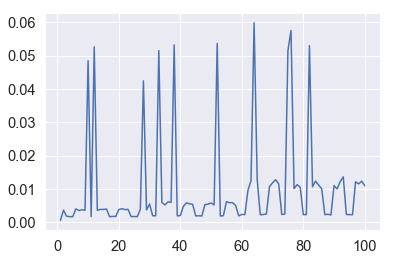

In [414]:
df_prob_fam.loc[0].plot()

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3,3,5,8,3,9,4,1,2,6,...,0,4,7,2,0,9,1,1,8,6
1,7,3,0,6,0,9,9,4,8,7,...,2,3,3,3,5,1,1,9,2,3
2,1,4,1,10,4,1,5,7,5,5,...,0,4,6,6,7,0,8,4,8,5
3,4,9,6,0,6,6,2,5,5,1,...,7,7,8,4,2,6,10,2,2,4
4,8,7,7,5,3,4,5,2,8,3,...,5,8,8,0,6,7,1,1,8,10


### Treatment of choices

In [267]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,82,5,82,9,93,2,91,11,1,96,...,47,83,32,89,52,60,66,66,26,96
1,76,5,100,40,53,2,99,10,53,47,...,74,1,90,66,87,1,66,7,4,80
2,38,11,54,54,26,59,32,50,33,18,...,47,83,76,81,47,16,59,27,26,40
3,33,61,10,2,46,35,1,17,33,88,...,94,14,1,28,1,56,42,54,4,88
4,10,6,89,6,93,60,32,52,53,50,...,46,91,1,62,16,46,66,66,26,22
5,52,5,27,96,39,26,57,88,1,39,...,5,49,52,1,13,33,81,54,12,39
6,38,40,27,59,1,32,99,11,1,28,...,61,75,32,1,47,56,24,74,53,39
7,33,97,25,93,3,59,88,17,33,96,...,74,29,1,40,54,66,17,66,53,80
8,75,11,80,6,46,78,4,88,18,39,...,4,47,66,88,54,33,91,66,17,96
9,52,11,25,32,93,12,57,48,12,18,...,32,83,22,81,1,16,88,23,70,39


### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

,cost
0,4.405331e+62
1,8.627548e+56
2,1.346244e+59
3,5.624646e+61
4,7.746507e+61
5,2.343082e+51
6,4.598295e+66
7,7.982710e+56
8,1.347359e+57
9,1.105799e+60


In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [336]:
best_0 = best.copy()

In [338]:
best_0[0] = 

In [339]:
cost_function(best_0)

penalty for only families:  668724
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 240, 51: 206, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5693.956505273219


674417.9565052732

In [311]:
cost_function(df_pop.loc[0].tolist())

penalty for only families:  2162615
daily_occupancy:  {100: 61, 99: 49, 98: 48, 97: 61, 96: 236, 95: 291, 94: 282, 93: 55, 92: 59, 91: 42, 90: 45, 89: 289, 88: 250, 87: 229, 86: 58, 85: 80, 84: 32, 83: 77, 82: 267, 81: 275, 80: 261, 79: 131, 78: 58, 77: 57, 76: 41, 75: 328, 74: 278, 73: 235, 72: 84, 71: 61, 70: 81, 69: 51, 68: 265, 67: 288, 66: 311, 65: 103, 64: 49, 63: 46, 62: 112, 61: 300, 60: 298, 59: 253, 58: 146, 57: 113, 56: 110, 55: 130, 54: 351, 53: 343, 52: 293, 51: 164, 50: 147, 49: 107, 48: 159, 47: 354, 46: 320, 45: 285, 44: 121, 43: 101, 42: 129, 41: 148, 40: 366, 39: 410, 38: 304, 37: 111, 36: 136, 35: 130, 34: 151, 33: 306, 32: 367, 31: 333, 30: 129, 29: 182, 28: 154, 27: 186, 26: 309, 25: 333, 24: 337, 23: 175, 22: 176, 21: 145, 20: 213, 19: 373, 18: 386, 17: 443, 16: 163, 15: 153, 14: 181, 13: 196, 12: 423, 11: 338, 10: 332, 9: 178, 8: 146, 7: 119, 6: 169, 5: 374, 4: 371, 3: 426, 2: 147, 1: 1134}
accounting_cost:  1.6873275561551044e+62


1.6873275561551044e+62

In [ ]:
cost_function(best)

In [288]:
cost_family(1,0)

0

In [286]:
df_pop.loc[0].tolist()[1]

5

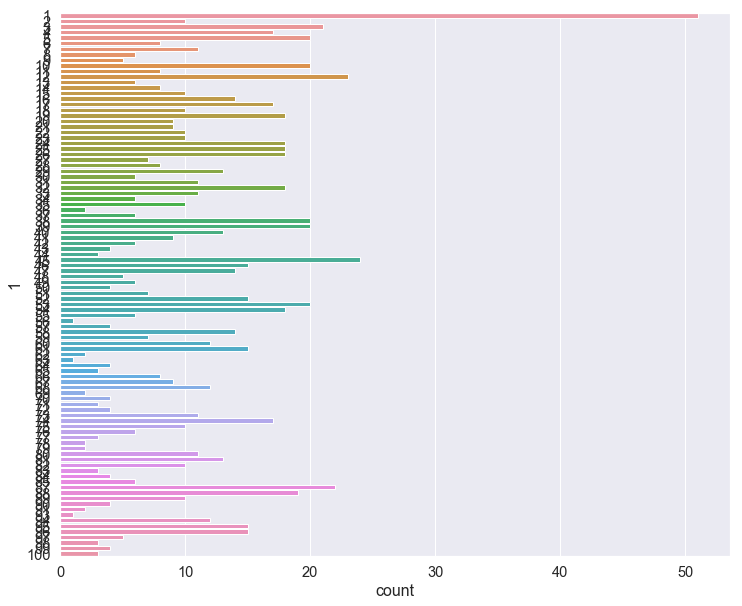

In [303]:
fig = plt.figure(figsize=(12, 10)) 
ax = sns.countplot(y=df_pop.index, data=df_pop.loc[1])

## From baseline

In [11]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [13]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 families choices from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [14]:
# check baseline
cost_function(submission['assigned_day'])

672254.0276683343

In [81]:
# try to select day from random between +/- delta day

def find_day_range(day_curr):
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [82]:
# create 1000 family choices from baseline :
# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

In [83]:
# create 1000 family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

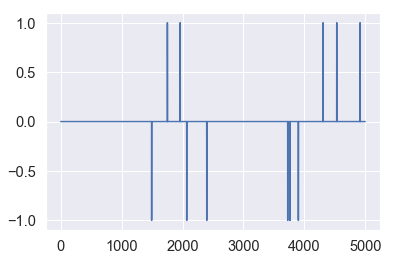

In [85]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

### Evaluation #1

In [260]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [261]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

,cost
0,672254.027668
21,673249.435665
632,675341.022931
587,675579.598524
904,675800.361230
552,676043.157413
148,676060.161931
215,676639.495767
599,676960.819718
550,677205.766828


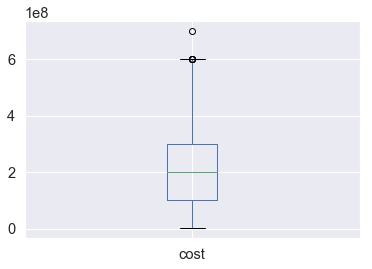

In [262]:
df_cost.boxplot()

### Loop over generations

In [254]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

(1000, 5000)

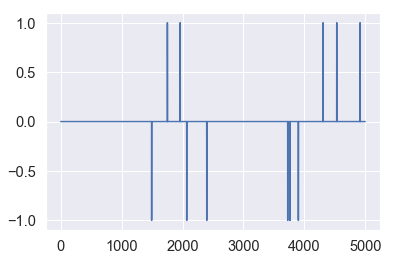

In [263]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [264]:
# LOOP OVER GENERATIONS 
for gen_id in range(0, 100):
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    # Keep the best indiv.
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    name_best = df_cost_sort.iloc[0].name
    best_indiv = df_pop.loc[name_best]

    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    print("df_cost_sort.shape: ", df_cost_sort.shape)
    # select randomly survivors (have to be an even number)
    nb_survivor = int(df_cost_sort.shape[0]*(1-R_POP_LOST))
    print("nb_survivor: ", nb_survivor)
    if nb_survivor % 2 != 0:
        nb_survivor += 1
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # check if previous best is still here
    if name_best not in vect_survivor:
        # else replace by prevous best
        vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(best_indiv, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(5))


 
GENERATION #0 / nb. pop: 1000
df_cost_sort.shape:  (1000, 3)
nb_survivor:  950
              cost
950  672254.027668
738  674698.020456
168  676769.022149
708  677146.147313
109  677429.572298
847  677489.508860
926  677508.871687
64   677734.121297
331  677843.204927
330  677902.566933


In [234]:
df_test = df_pop.append(best_indiv, ignore_index=True)
df_test

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
5,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
6,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
7,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
8,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
9,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


In [228]:
indice_mut

array([283, 128, 607, 466, 785, 381, 900, 991, 711, 532, 294,  66, 347,
       227, 892, 433,  92, 224, 293, 685, 838,   2, 172,  68,  69, 972,
        69,  20, 214, 206, 458, 467, 904, 887, 486, 827, 451,  64,  36,
       116, 583, 822, 659, 451, 232, 640, 969])

283


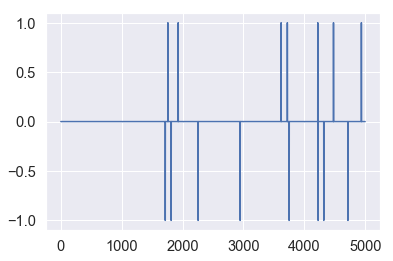

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

In [231]:
0.01*5000

50.0

283


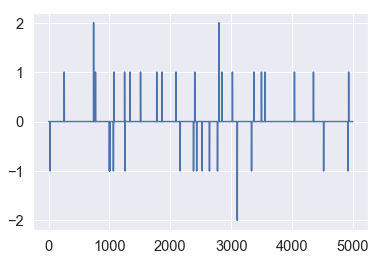

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

In [226]:
df_pop_cross

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
927,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
173,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
288,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
587,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
528,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
21,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
148,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
316,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
247,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


In [224]:
df_pop_surv

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
927,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
173,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
288,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
587,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
528,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,89,32,67,13
21,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
148,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
316,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
247,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


In [218]:
indice_mut

array([961, 694, 842, 744, 753, 460, 210, 903,  84, 209, 850, 523,  52,
       819,  48, 973, 324,  69, 142, 401,  43, 456, 959, 848, 596,  33,
       341, 515, 639, 195, 646,  84, 515, 498, 378, 783, 841, 400, 801,
       896, 628, 910, 547, 814, 742, 874, 895])

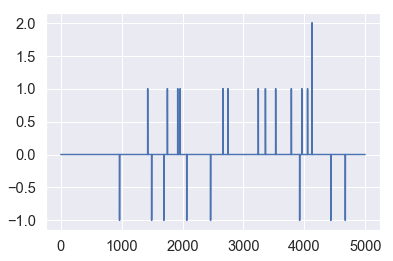

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [201]:
if name_best in df_pop.index.tolist():
    print("YES")

YES


In [196]:
df_pop.index.tolist().remove(name_best)

In [194]:
df_pop.shape[0]

950

In [190]:
df_pop.head()

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
460,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
632,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
657,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
683,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


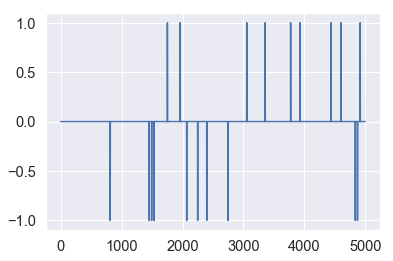

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [176]:
vect_id_1_part_0 vect_id_1_part_1

5000

In [177]:
df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)

In [158]:
arr_pairs.shape

(475, 2)

In [157]:
df_pop

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
927,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
673,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
247,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
513,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
871,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
664,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
66,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
651,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
173,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


In [148]:
np.random.choice([1,2,3,4,5,6], replace=False,
                    size=(2,2))

array([[1, 6],
       [5, 3]])

In [152]:
vect_survivor

array([410,   0, 904, 956, 550, 209, 323, 183, 939, 446, 505, 467, 157,
       148, 871, 906, 950, 356, 412, 192,  57, 397, 334, 632, 580, 478,
       215, 247, 315, 528, 173, 894,  45, 798,  21, 587, 679, 177, 159,
       536,  20, 816, 751, 421, 677, 144, 620, 898, 599, 982,  40, 226,
       552, 392, 686, 664, 227, 508, 500, 185, 125, 217, 769, 704, 284,
       895, 301, 778, 673, 496, 622,  54, 662,  52, 509, 517, 169, 765,
       228, 977, 504, 222, 851, 774, 111, 639, 483, 179, 993, 102, 353,
       223, 572, 614, 811, 103, 316, 272, 475, 156, 101, 160, 630, 635,
       835, 510,   1, 945, 941, 460,  44, 342, 513, 595, 746, 345, 277,
       603, 430, 547,  67,  37,  10, 304, 482, 204, 210, 494, 234, 862,
       581, 875, 546, 747, 582, 759, 866, 225, 476, 691, 757,  13, 480,
       833, 248,  92, 559, 711, 861, 534, 986, 850, 391, 893, 841, 233,
       682, 404, 239, 703, 307, 465,  11, 755, 352, 680, 424, 140, 278,
       295, 991, 563, 615, 126,  33, 532, 715,  15, 957, 605, 49